In [11]:
# pytorch 随便拉个模型，熟悉一下流程

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
from matplotlib.pylab import plt
import torch.nn as nn
import torchvision.transforms.functional as TF

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

In [3]:
class CCPDDataset(Dataset):
    def __init__(self, imgs_path, transform=None):
        self.filepath = imgs_path
        self.filenames = os.listdir(imgs_path)
        while ".DS_Store" in self.filenames:
            self.filenames.remove(".DS_Store")
        self.transform = transform
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, index):
        filename = self.filenames[index]
        # 图片数据
        img = Image.open(os.path.join(self.filepath, filename)).convert("RGB")
        # 找出带有车牌信息的文件名(chaos_name)以及扩展名(extension_name)
        chaos_name, _ = filename.split(os.sep)[-1].split(".")
        # 解析 chaos_name
        [area_ratio, tilt_degree, bounding_box_coordinates, 
            four_vertices_locations, license_plate_number, brightness, \
            blurriness] = chaos_name.split("-")
        # four_vertices_locations 四个顶点的位置
        four_vertices_locations_str_array = four_vertices_locations.split("_")
        self.four_vertices_locations = []
        for xy_str in four_vertices_locations_str_array:
            x_str, y_str = xy_str.split("&")
            self.four_vertices_locations += [int(x_str), int(y_str)]
        label = self.four_vertices_locations
        # TODO: transform
        if self.transform:
            img, label = self.transform(img, label)
        return img, label


In [4]:
def transformer(img, label):
    label = np.array(label)
    img = TF.to_tensor(img)
    return img, label

In [5]:
def show_img(img, label):
    assert len(label) == 8 and type(label) == np.ndarray
    plt.imshow(img)
    [a,b,c,d,e,f,g,h] = label
    plt.plot([a, c, e, g, a], [b, d, f, h, b], color="red")
    # for i in range(0, 1160, 10):
    #     plt.plot([0, 720], [i, i], color="white")
    # for i in range(0, 720, 10):
    #     plt.plot([i, i], [0, 1160], color="white")

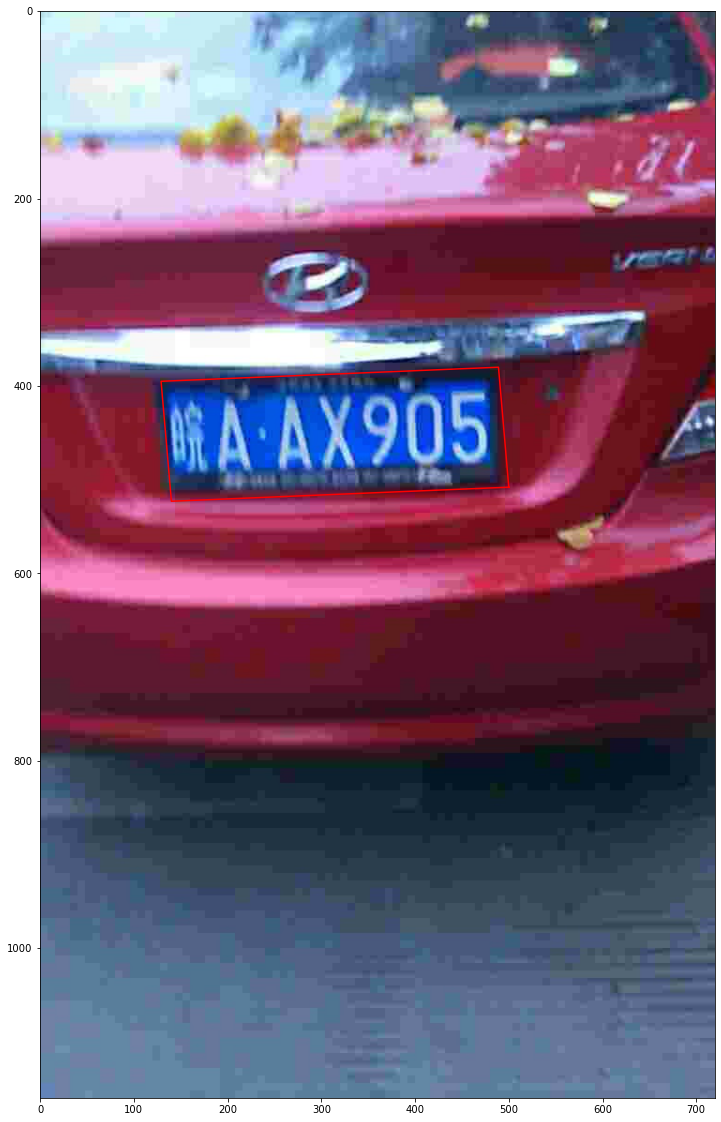

In [6]:
# test
dataset = CCPDDataset("samples/CCPD-base", transform=transformer)
img, label = dataset[9]
show_img(img, label)

In [7]:
# 这个模型是为了熟悉 PyTorch 流程乱配的

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=32*8*4, out_features=8*16),
    nn.ReLU(),
    nn.Linear(in_features=8*16, out_features=8),
)

# x = torch.rand(1,3,1160,720)
# y = model(x)
# y.shape
# -> [1,8]

In [8]:
dl = DataLoader(dataset, batch_size=2, shuffle=True)

In [10]:
for d in dl:
    print(type(d))
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>